<a href="https://colab.research.google.com/github/arkajyotiMukherjee/tensorflow_docs_prac/blob/master/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# Backup images
content_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [0]:
# Load image and make transformations
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [0]:
# Display the Image

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
    
  plt.imshow(image)
  if title:
    plt.title(title)

In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  return list(uploaded.keys())

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


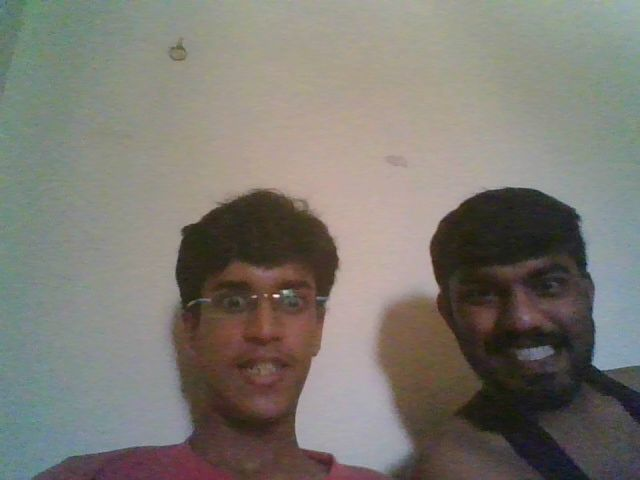

In [38]:
from IPython.display import Image
try:
  content_upload_path = take_photo()
  print('Saved to {}'.format(content_upload_path))
  
  # Show the image which was just taken.
  display(Image(content_upload_path))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [9]:
# Upload content image
content_upload_path_list = upload_files()

Saving punisher-daredevil-season-2-trailer-tease.jpg to punisher-daredevil-season-2-trailer-tease (1).jpg


In [10]:
# Upload style image
style_upload_path_list = upload_files()

Saving unnamed.jpg to unnamed (1).jpg


In [11]:
import os
!ls
os.getcwd()

 4k-wallpapers-9-Desktop-Backgrounds-1024x640.jpg
 600dpi.jpg
 608422.jpg
 890f1fe65f88ab3491cf56f6b6db9f61.jpg
 890f1_Rober.png
'b0005c0638f372d1 (1).png'
 b0005c0638f372d1.png
 photo_b0005.png
 photo.jpg
 photo_pure-.png
 photo_s1167.png
'punisher-daredevil-season-2-trailer-tease (1).jpg'
 punisher-daredevil-season-2-trailer-tease.jpg
'pure-joy-1-abstract-art-by-sharon-cummings-sharon-cummings (1).jpg'
'pure-joy-1-abstract-art-by-sharon-cummings-sharon-cummings (2).jpg'
 pure-joy-1-abstract-art-by-sharon-cummings-sharon-cummings.jpg
 RobertBeatty-itsnicethat-hero.png
 s116722903592714182_p24_i3_w768.jpeg
 sample_data
'unnamed (1).jpg'
 unnamed.jpg


'/content'

In [13]:
content_image_name = content_upload_path_list[0]
content_path = '/content/' + content_image_name

style_image_name = style_upload_path_list[0]
style_path = '/content/' + style_image_name
print(content_path, style_path)

/content/punisher-daredevil-season-2-trailer-tease.jpg /content/unnamed.jpg


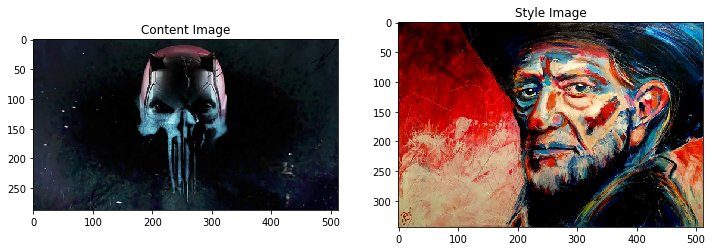

In [14]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [15]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layers in vgg.layers:
  print(layers.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
#   print(outputs)
  
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [18]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 344, 512, 64)
  min:  0.0
  max:  806.20245
  mean:  28.504574

block2_conv1
  shape:  (1, 172, 256, 128)
  min:  0.0
  max:  4676.934
  mean:  147.17175

block3_conv1
  shape:  (1, 86, 128, 256)
  min:  0.0
  max:  9103.611
  mean:  155.05351

block4_conv1
  shape:  (1, 43, 64, 512)
  min:  0.0
  max:  17808.932
  mean:  576.34393

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3549.2686
  mean:  43.783978



In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc, bijd -> bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  return result/num_locations

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [21]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  60009.47
    mean:  598.49475

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  67519.836
    mean:  13907.126

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.109376
    max:  221510.67
    mean:  11201.17

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5501250.5
    mean:  174872.45

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  50722.02
    mean:  841.0945

Contents:
   block5_conv2
    shape:  (1, 17, 32, 512)
    min:  0.0
    max:  915.6478
    mean:  9.433201


In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
# Weighted combination of the two losses will give the total loss
style_weight = 1e-2
content_weight = 1e4

In [0]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                       for name in style_outputs.keys()])
  style_loss *= style_weight/num_style_layers
  
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                       for name in content_outputs.keys()])
  content_loss *= content_weight/num_content_layers
  
  loss = style_loss + content_loss
  return loss

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    
  grads = tape.gradient(loss, image)
  optimizer.apply_gradients([(grads, image)])
  image.assign(clip_0_1(image))

In [0]:
# Test

# for i in range(5):
#   train_step(image)

# plt.imshow(image.read_value()[0])

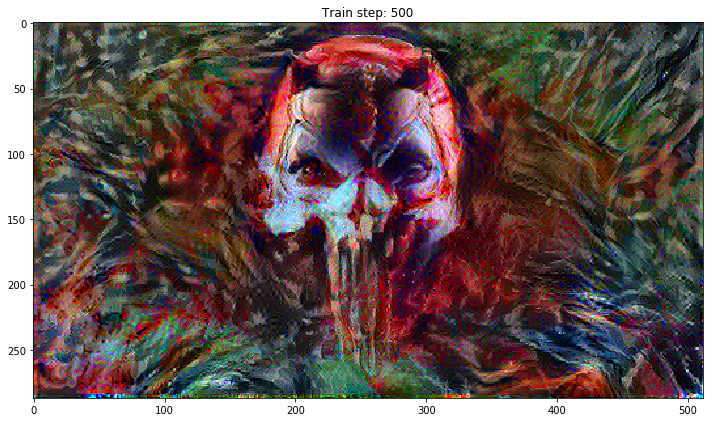

Total time: 79.36


In [29]:
import IPython.display as display
# Initialize the variable
image = tf.Variable(content_image)

start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0

for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  imshow(image)
  plt.title('Train step: {}'.format(step))
  plt.show()
  
end = time.time()
print('Total time: {:.2f}'.format(end-start))

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  
  return x_var, y_var

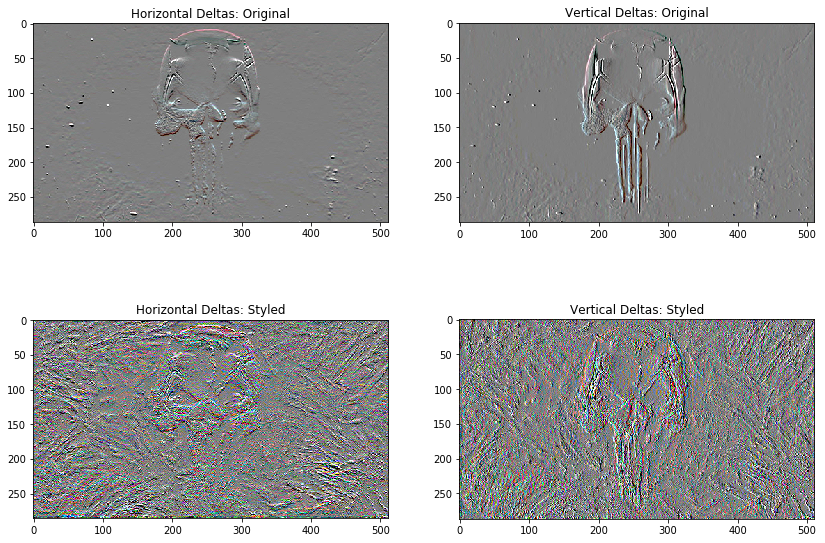

In [31]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [0]:
def total_variational_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [0]:
total_variational_weight = 1e8

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variational_weight * total_variational_loss(image)
    
  grads = tape.gradient(loss, image)
  optimizer.apply_gradients([(grads, image)])
  image.assign(clip_0_1(image))

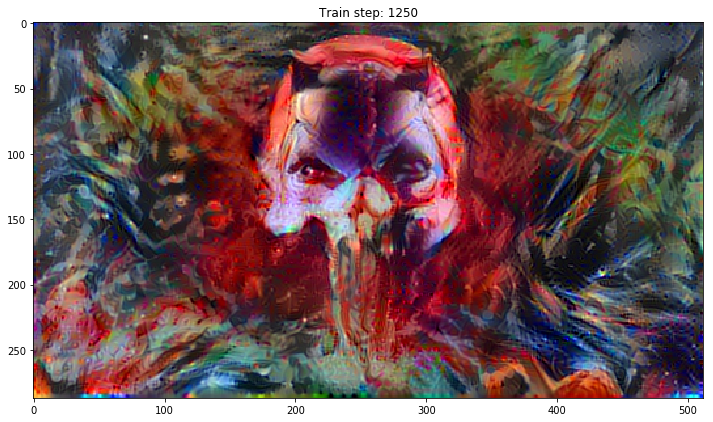

Total time: 191.39


In [35]:
import IPython.display as display
# Initialize the variable
image = tf.Variable(content_image)

start = time.time()

epochs = 25
steps_per_epoch = 50

step = 0

for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  imshow(image)
  plt.title('Train step: {}'.format(step))
  plt.show()
  
end = time.time()
print('Total time: {:.2f}'.format(end-start))

In [0]:
file_name = content_image_name[:5] + '_' + style_image_name[:5] + '.png'

mpl.image.imsave(file_name, image[0])

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)